## LASSO and Random Forest fits

# Load/import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
#from sklearn.metrics import mean_squared_error,mean_absolute_error

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from preprocess import *

# Data

## Download

**Should really define a function that downloads the data and loads it**

In [3]:
# bxm,bym,jxm,jym,emfx,emfy,u2tot,b2tot
# tres,Rm,uave,kf,tt
pth='../data/alpha2/'

mf15 = np.load(pth + 'mfields_R15e3.npz')
mf9  = np.load(pth + 'mfields_R9e3.npz') 
mf5  = np.load(pth + 'mfields_R5e3.npz')
mf1  = np.load(pth + 'mfields_R1e3.npz') 
mf05 = np.load(pth + 'mfields_R5e2.npz')

## Pre-process

Time averaged data stored in a pandas dataframe

In [4]:
df15 = gen_df_tave(fname=pth + 'mfields_R15e3.npz',t1=1500,t2=-1,verbose=0)
df9  = gen_df_tave(fname=pth + 'mfields_R9e3.npz',t1=1500,t2=-1,verbose=0)
df5  = gen_df_tave(fname=pth + 'mfields_R5e3.npz',t1=1000,t2=-1,verbose=0)
df1  = gen_df_tave(fname=pth + 'mfields_R1e3.npz',t1=1250,t2=2000,verbose=0)
df05 = gen_df_tave(fname=pth + 'mfields_R5e2.npz',t1=4000,t2=5000,verbose=0)

# Lasso

In [5]:
from lasso_fits import *

## Polynomial basis

Feature names: ['Bx', 'By', 'Bx By', 'Ex', 'Ey', 'B^2', 'B^2 Bx', 'B^2 By']
Feature array shape: (256, 8)
Test size: 0.2
Test,train shapes: (52, 6) (204, 6)
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Tuned Lasso Alpha: {'lasso__alpha': 0.001}
Tuned Lasso Score: -0.09933501689027614
BEST FIT model
Mean Absolute Error: 0.09933501689027614
LASSO score: 0.3495967996444914
Coefficients: [-0.00131554  0.20634955 -0.02181149  0.76528774 -0.         -0.01298382]


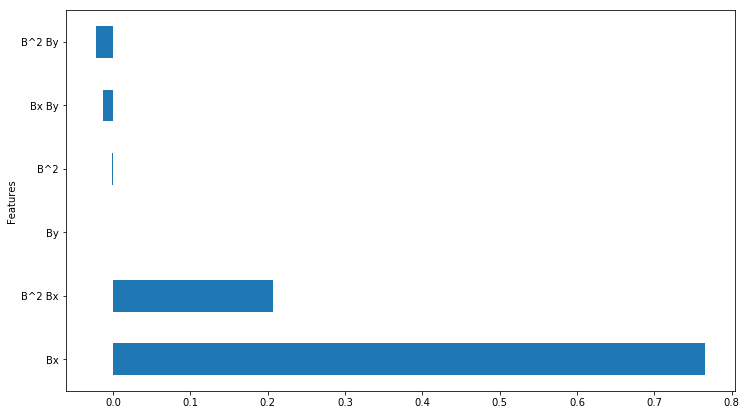

In [6]:
df15_poly = gen_df_poly(df15)
df15_ss, scl = scale_df(df15_poly)
y_train,y_pred,y_test = lasso_gridcv(df15_ss)

# Random forests

In [7]:
from rf_fits import *

## Polynomial basis

Test size: 0.2
Test,train shapes: (52, 6) (204, 6)
Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    1.6s finished


MAE: 0.12403470613699762
Tuned RF params: {'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 4, 'rf__n_estimators': 32}
Tuned RF score:  -0.12403470613699762
MAE: 0.12403470613699762
R^2: -0.32777353093283246
Best model important features: SKLEARN
[3.64540743e-03 6.90994466e-01 2.67069691e-04 3.04450345e-01
 2.77672694e-04 3.65038671e-04]


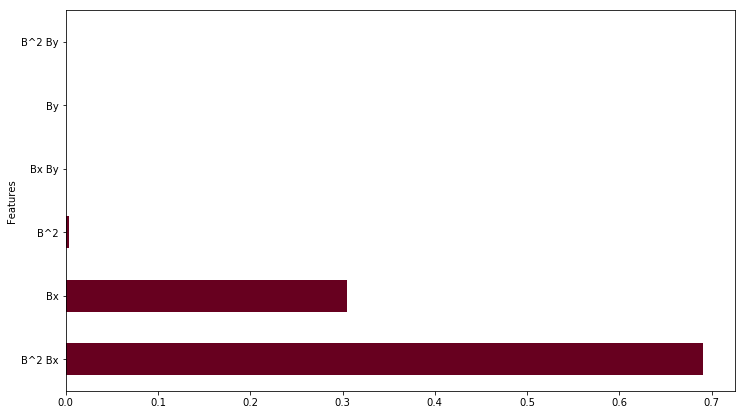

In [8]:
df15_ss, _ = scale_df(df15_poly)
y_trainrf,y_predrf,y_testrf = rf_gridcv(df15_ss)#, fi_plts=True)

## Visualize individual trees

In [9]:
# Load the best model chosen by grid search

from joblib import load
bst_rf_poly = load('bst_rf.joblib')
estimator = bst_rf_poly.estimators_[5]
estimator

DecisionTreeRegressor(criterion='mae', max_depth=8, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1201263687, splitter='best')

In [10]:
from sklearn.tree import export_graphviz
import pydotplus
import collections
#from IPython import display

flds = ['Ex','Ey']
df_feats = df15_ss.drop(flds,axis=1)

tree0 = export_graphviz(estimator,
                feature_names=df_feats.columns,
                filled=True,
                rounded=True,
                rotate=True)
#display.display(tree0)

graph = pydotplus.graph_from_dot_data(tree0)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])
        
graph.write_png('tree_poly.png')

True

In [11]:
# Uncomment to display the tree in jupyter 
#from IPython.display import Image
#Image(graph.create_png())

## Sci-kit Learn's Feature Importances

In [12]:
from joblib import load
bst_rf_poly = load('bst_rf.joblib')
bst_rf_poly.feature_importances_

array([3.64540743e-03, 6.90994466e-01, 2.67069691e-04, 3.04450345e-01,
       2.77672694e-04, 3.65038671e-04])

In [13]:
bst_lasso_poly = load('bst_lasso.joblib')
print(bst_lasso_poly.coef_,bst_lasso_poly.coef_.shape)

[-0.00131554  0.20634955 -0.02181149  0.76528774 -0.         -0.01298382] (6,)


In [14]:
flds = ['Ex','Ey']
df_feats = df15_ss.drop(flds,axis=1)
x_feats = list(df_feats.columns)

In [15]:
#plt.bar(x_feats, bst_rf.feature_importances_, color=['red','green','blue','black'])
#plt.bar(x_feats, bst_lasso.coef_, color=['k','y','k','y'])

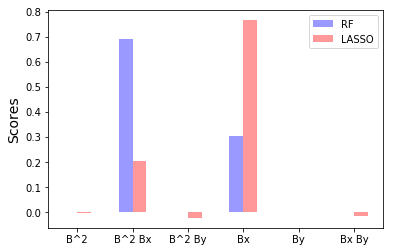

In [16]:
n_groups = 6 # changed for polynomial - 6 terms instead of 4
index = np.arange(n_groups)
bar_width = 0.25
xlabs = [r'$\overline{B}_x$', r'$\overline{B}_y$', 
         r'$\overline{J}_x$', r'$\overline{J}_y$']

opacity = 0.4
error_config = {'ecolor': '0.3'}

fig, ax = plt.subplots()

rects1 = ax.bar(index, bst_rf_poly.feature_importances_, bar_width,
                alpha=opacity, color='b',
                #yerr=std_men, error_kw=error_config,
                label='RF')

rects2 = ax.bar(index + bar_width, bst_lasso_poly.coef_, bar_width,
                alpha=opacity, color='r',
                #yerr=std_women, error_kw=error_config,
                label='LASSO')

#ax.set_xlabel('Fields')
ax.set_ylabel('Scores', fontsize=14)
#ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_feats)
#ax.set_xticklabels(xlabs, fontsize=14)
ax.legend()

#fig.tight_layout()
#plt.show()

fig.savefig('RFvsLASSO_poly.pdf', bbox_inches='tight')

## Comparison: RF vs LASSO

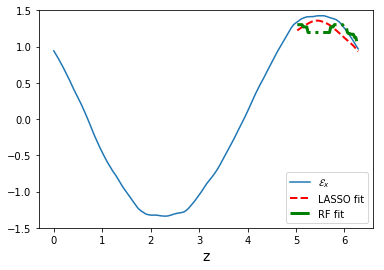

In [17]:
z_ax = np.linspace(0,2*np.pi,256)

fig,ax=plt.subplots()
        
fld_label = r"$\mathcal{E}_x$" #if fld=='Ex' else r"$\mathcal{E}_y$"
        
ax.plot(np.linspace(0,2*np.pi,256),df15_ss['Ex'],label=fld_label)
ax.plot(z_ax[y_train.shape[0]:],y_pred,'r--',lw=2,label="LASSO fit")
ax.plot(z_ax[y_train.shape[0]:],y_predrf,'g-.',lw=3,label="RF fit")
        
ax.set_ylim([-1.5,1.5])
    
ax.legend()
ax.set_xlabel('z',fontsize=14)
    
fig.savefig('df15_SPACE_comparison_poly.pdf',bbox_inches='tight')